In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import tensorflow as tf

2023-05-07 17:00:31.908374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_lsq_results(result_dir: str,
                           num_runs: int,
                           failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_ts_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [5]:
def process_original_albo_lsq_results(result_dir: str,
                                      num_runs: int,
                                      failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [6]:
def process_original_albo_gsbp_results(result_dir: str,
                                       num_runs: int,
                                       failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.5, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

### LSQ

In [131]:
ts_al_adam_lsq_results, ts_al_adam_lsq_results_mean, ts_al_adam_lsq_results_median, ts_al_adam_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/adam/data/", 100, 1.7)
ts_al_bfgs_lsq_results, ts_al_bfgs_lsq_results_mean, ts_al_bfgs_lsq_results_median, ts_al_bfgs_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/l_bfgs_b/data/", 100, 1.7)
original_albo_lsq_results, original_albo_lsq_results_mean, original_albo_lsq_results_median, original_albo_lsq_results_std = process_original_albo_lsq_results("../results/final_original_results/lsq/slack_optim/data/", 100, 1.4)
ts_al_adam_rbf_lsq_results, ts_al_adam_rbf_lsq_results_mean, ts_al_adam_rbf_lsq_results_median, ts_al_adam_rbf_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/adam_no_prev_rbf/data/", 100, 1.7)
random_lsq_results, random_lsq_results_mean, random_lsq_results_median, random_lsq_results_std = process_ts_lsq_results("../results/11-04-23/lsq_random/", 100, 1.4)
consistent_results, consistent_results_mean, consistent_results_median, consistent_results_std = process_ts_lsq_results("../results/14-04-23/lsq_fully_consistent/data/", 100, 1.4)

In [134]:
print(ts_al_adam_rbf_lsq_results_median)

[1.68789063 1.29882812 1.19726562 1.08007812 1.06640625 1.00390625
 1.         0.99921893 0.98696204 0.875      0.80585566 0.76991002
 0.75309093 0.65986423 0.62742902 0.61246414 0.60201054 0.60077236
 0.60051134 0.60032796 0.60023788 0.60015558 0.6000859  0.60002483
 0.59999068 0.59996927 0.59995038 0.59994979 0.59994205 0.59993003
 0.59991946 0.59991829 0.59991208 0.59990959 0.59989827 0.59989827
 0.5998964  0.59989289 0.59989154 0.59989154 0.59988938 0.59988399
 0.59988399 0.59988399 0.59987975]


In [141]:
print(original_albo_lsq_results[:, -1])

[0.59995088 0.59992512 0.59984898 0.60047349 0.59991834 0.61620964
 0.62143035 0.59979279 0.59980956 0.59991064 0.59983831 0.60037864
 0.60091579 0.59996303 0.59988745 0.60000496 0.59982411 0.59995373
 0.59985781 0.5998778  0.59988548 0.60021088 0.59987285 0.59983021
 0.59989559 0.59982434 0.60033637 0.59988562 0.59985891 0.60038246
 0.59980649 0.59992204 0.60079342 0.59987967 0.59979334 0.59994351
 0.60006165 0.59983485 0.59979352 0.60037039 0.59980301 0.59983514
 0.59987108 0.59985239 0.60006806 0.59989766 0.59989691 0.59998464
 0.59987045 0.59999431 0.59981225 0.59990008 0.59995924 0.60028812
 0.60002073 0.59982307 0.59983352 0.59981174 0.59996509 0.60025807
 0.59980202 0.60043456 0.59979989 0.59993975 0.60053173 0.60012854
 0.60080909 0.59985562 0.6000919  0.599811   0.59984409 0.59985349
 0.59993535 0.60006129 0.59980789 0.59996885 0.59983274 0.59990009
 0.60002189 0.5998294  0.59998463 0.59990022 0.61338062 0.59985802
 0.60001075 0.59985578 0.5998966  0.59991263 0.60005087 0.5998

In [135]:
print(ts_al_adam_lsq_results_median)

[1.68789063 1.29882812 1.19726562 1.08007812 1.06640625 1.00390625
 1.00321582 1.         0.98632812 0.93447773 0.921875   0.87890625
 0.77320932 0.68268374 0.65508163 0.64520415 0.61528349 0.60254465
 0.60140314 0.60024084 0.60002508 0.59998283 0.59993565 0.59987842
 0.59987078 0.59986694 0.59985791 0.59983829 0.59982868 0.59982456
 0.59981924 0.59981727 0.59981727 0.59981651 0.59981492 0.59981386
 0.59981043 0.59980877 0.59980877 0.59980665 0.59980665 0.59980654
 0.59980554 0.59980495 0.59980435]


In [8]:
ts_al_adam_lsq_results.shape

(100, 45)

In [9]:
original_albo_lsq_results.shape

(100, 45)

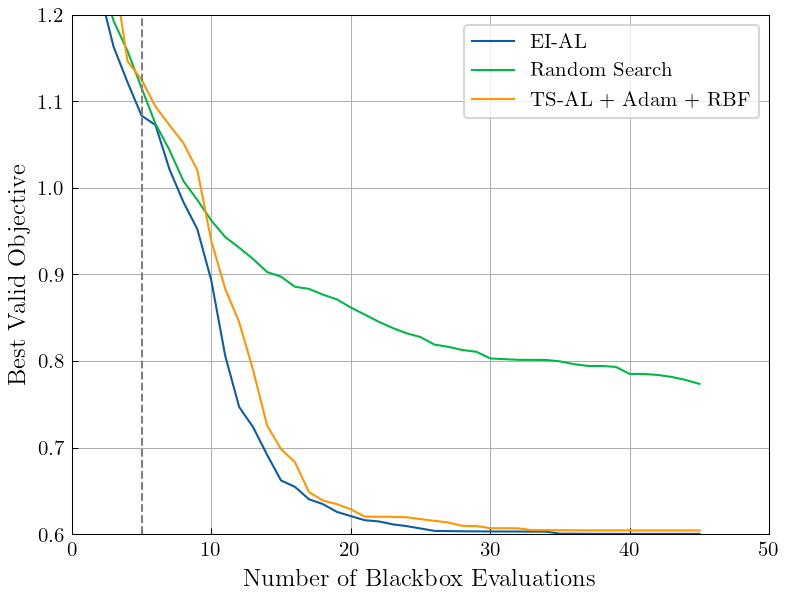

In [138]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 46)]
# plt.plot(iters, ts_al_kkt_lsq_results_mean[:50], label="TS-AL Gradient Update")
# plt.plot(iters, ts_al_original_lsq_results_mean[:50], label="TS-AL Original Update")
# plt.plot(iters, consistent_results_mean[:45], label="Fully Consistent")
plt.plot(iters, original_albo_lsq_results_mean, label="EI-AL")
plt.plot(iters, random_lsq_results_mean[:45], label="Random Search")
# plt.plot(iters, ts_al_adam_lsq_results_mean, label="TS-AL + Adam")
# plt.plot(iters, ts_al_bfgs_lsq_results_mean, label="TS-AL + L-BFGS-B")
plt.plot(iters, ts_al_adam_rbf_lsq_results_mean, label="TS-AL + Adam + RBF")
plt.axvline(x=5, color='grey', linestyle='--')
# plt.fill_between(iters, original_albo_lsq_results_mean[:45]+original_albo_lsq_results_std[:45], original_albo_lsq_results_mean[:50]-original_albo_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, random_lsq_results_mean[:50]+random_lsq_results_std[:50], random_lsq_results_mean[:50]-random_lsq_results_std[:50], alpha=0.1, linestyle='-', linewidth=2)
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 50)
plt.ylim(0.6, 1.2)
plt.show()

### GSBP

In [7]:
ts_al_adam_aggressive_gsbp_results, ts_al_adam_aggressive_gsbp_results_mean, ts_al_adam_aggressive_gsbp_results_median, ts_al_adam_aggressive_gsbp_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_conservative_gsbp_results, ts_al_adam_conservative_gsbp_results_mean, ts_al_adam_conservative_gsbp_results_median, ts_al_adam_conservative_gsbp_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_conservative/data/", 50, 2.1, equality_tolerance=0.01)
original_albo_aggressive_gsbp_results, original_albo_aggressive_gsbp_results_mean, original_albo_aggressive_gsbp_results_median, original_albo_aggressive_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_aggressive/data/", 50, 2.1)
original_albo_conservative_gsbp_results, original_albo_conservative_gsbp_results_mean, original_albo_conservative_gsbp_results_median, original_albo_conservative_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_conservative/data/", 50, 2.1)
random_gsbp_results, random_gsbp_results_mean, random_gsbp_results_median, random_gsbp_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_random/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_aggressive_results, ts_al_adam_no_prev_aggressive_results_mean, ts_al_adam_no_prev_aggressive_results_median, ts_al_adam_no_prev_aggressive_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_conservative_results, ts_al_adam_no_prev_conservative_results_mean, ts_al_adam_no_prev_conservative_results_median, ts_al_adam_no_prev_conservative_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_conservative/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_rbf_aggressive_results, ts_al_adam_no_prev_rbf_aggressive_results_mean, ts_al_adam_no_prev_rbf_aggressive_results_median, ts_al_adam_no_prev_rbf_aggressive_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_rbf_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_rbf_conservative_results, ts_al_adam_no_prev_rbf_conservative_results_mean, ts_al_adam_no_prev_rbf_conservative_results_median, ts_al_adam_no_prev_rbf_conservative_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_rbf_conservative/data/", 50, 2.1, equality_tolerance=0.01)

2023-05-07 17:15:08.876141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [100]:
print(ts_al_adam_no_prev_rbf_aggressive_results[:, 149])

[-0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951   0.31513912 -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951  -0.5273951
 -0.5273951  -0.5273951 ]


In [51]:
print(ts_al_adam_no_prev_aggressive_results[:, 149])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
  2.1       -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951  2.1      ]


In [29]:
print(ts_al_adam_no_prev_aggressive_results_mean)

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.0474521   1.95942655  1.75039609
  1.64530028  1.54091106  1.34674158  1.17275808  1.03308002  0.97972768
  0.90780702  0.67848456  0.55565337  0.41526268  0.34412274  0.25596623
  0.22264415  0.1533555   0.1533555   0.1533555   0.09994254  0.03050722
  0.03028656  0.03028656  0.03028656  0.01326189  0.01326189 -0.03975575
 -0.03975575 -0.03975575 -0.03975575 -0.03975575 -0.03975575 -0.03975575
 -0.03975575 -0.03975575 -0.03975575 -0.09230365 -0.09230365 -0.10911799
 -0.10911799 -0.10911799 -0.10911799 -0.10911799 -0.10911799 -0.1427137
 -0.1427137  -0.1427137  -0.1427137  -0.1952616  -0.1952616  -0.1952616
 -0.1952616  -0.1952616  -0.24780951 -0.24780951 -0.24780951 -0.2833075
 -0.2833075  -0.31973298 -0.31973298 -0.31973298 -0.31973298 -0.31973298
 -0.31973298 -0.33585541 -0.33585541 -0.33585541 -0.35270149 -0.3527

In [30]:
print(np.mean(ts_al_adam_aggressive_gsbp_results[:8, :], axis=0))

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         1.77157561  1.77157561  1.77157561  1.77157561  1.44315123
  1.44315123  1.44315123  1.44315123  1.22111196  0.89268757  0.89268757
  0.89268757  0.67086102  0.67086102  0.67086102  0.67086102  0.67086102
  0.67086102  0.67086102  0.67086102  0.67086102  0.34243663  0.34243663
  0.34243663  0.34243663  0.34243663  0.34243663  0.34243663  0.11739798
  0.11739798  0.11739798  0.11739798  0.11739798  0.11739798  0.11739798
  0.11739798  0.11739798  0.11739798  0.11739798  0.11739798  0.11739798
  0.11739798  0.11739798  0.11739798 -0.10741529 -0.10741529 -0.10741529
 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041
 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041
 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041
 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.21380041 -0.2

In [30]:
print(ts_al_adam_aggressive_gsbp_results_mean)

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.0474521   2.0474521   2.0474521   1.95942693  1.69668742
  1.59159161  1.48720239  1.32885191  1.13652541  0.96139594  0.90801459
  0.87202338  0.69489918  0.53647995  0.3442249   0.32525573  0.28933698
  0.28933698  0.23664594  0.23664594  0.23664594  0.18409804  0.13155014
  0.13155014  0.13155014  0.13155014  0.13155014  0.13155014  0.09554395
  0.09554395  0.09554395  0.09554395  0.09554395  0.09554395  0.09554395
  0.09554395  0.09554395  0.09554395  0.09554395  0.06015543  0.06004505
  0.06004505  0.06004505  0.06004505  0.02407492  0.02407492  0.02407492
  0.0070533   0.0070533   0.0070533   0.0070533   0.0070533   0.0070533
  0.0070533   0.0070533   0.0070533  -0.0286781  -0.0286781  -0.04563796
 -0.04563796 -0.08206092 -0.13460882 -0.13460882 -0.13460882 -0.13460882
 -0.13460882 -0.13460882 -0.13460882 -0.13460882 -0.13460882 -0.13

In [27]:
print(ts_al_adam_no_prev_aggressive_results_mean)

[ 2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.1         2.1         2.1
  2.1         2.1         2.1         2.03431512  1.96863024  1.70734217
  1.64165729  1.51117077  1.33414379  1.18129494  1.00669737  0.94000694
  0.8504668   0.56381373  0.45448589  0.32257506  0.25628697  0.146785
  0.12607664  0.10516313  0.10516313  0.10516313  0.03839692 -0.04839722
 -0.04867305 -0.04867305 -0.04867305 -0.06995389 -0.06995389 -0.13622593
 -0.13622593 -0.13622593 -0.13622593 -0.13622593 -0.13622593 -0.13622593
 -0.13622593 -0.13622593 -0.13622593 -0.20191081 -0.20191081 -0.22292874
 -0.22292874 -0.22292874 -0.22292874 -0.22292874 -0.22292874 -0.24359798
 -0.24359798 -0.24359798 -0.24359798 -0.24359798 -0.24359798 -0.24359798
 -0.24359798 -0.24359798 -0.30928286 -0.30928286 -0.30928286 -0.35365536
 -0.35365536 -0.3991872  -0.3991872  -0.3991872  -0.3991872  -0.3991872
 -0.3991872  -0.41934024 -0.41934024 -0.41934024 -0.44039784 -0.4403

In [39]:
a = [-0.5273951 for _ in range(24)]

In [42]:
a += [2.1]

In [44]:
np.mean(a)

-0.422299296

In [16]:
print(ts_al_adam_no_prev_aggressive_results[:20, 140])

[-0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951
 -0.5273951 -0.5273951 -0.5273951 -0.5273951 -0.5273951]


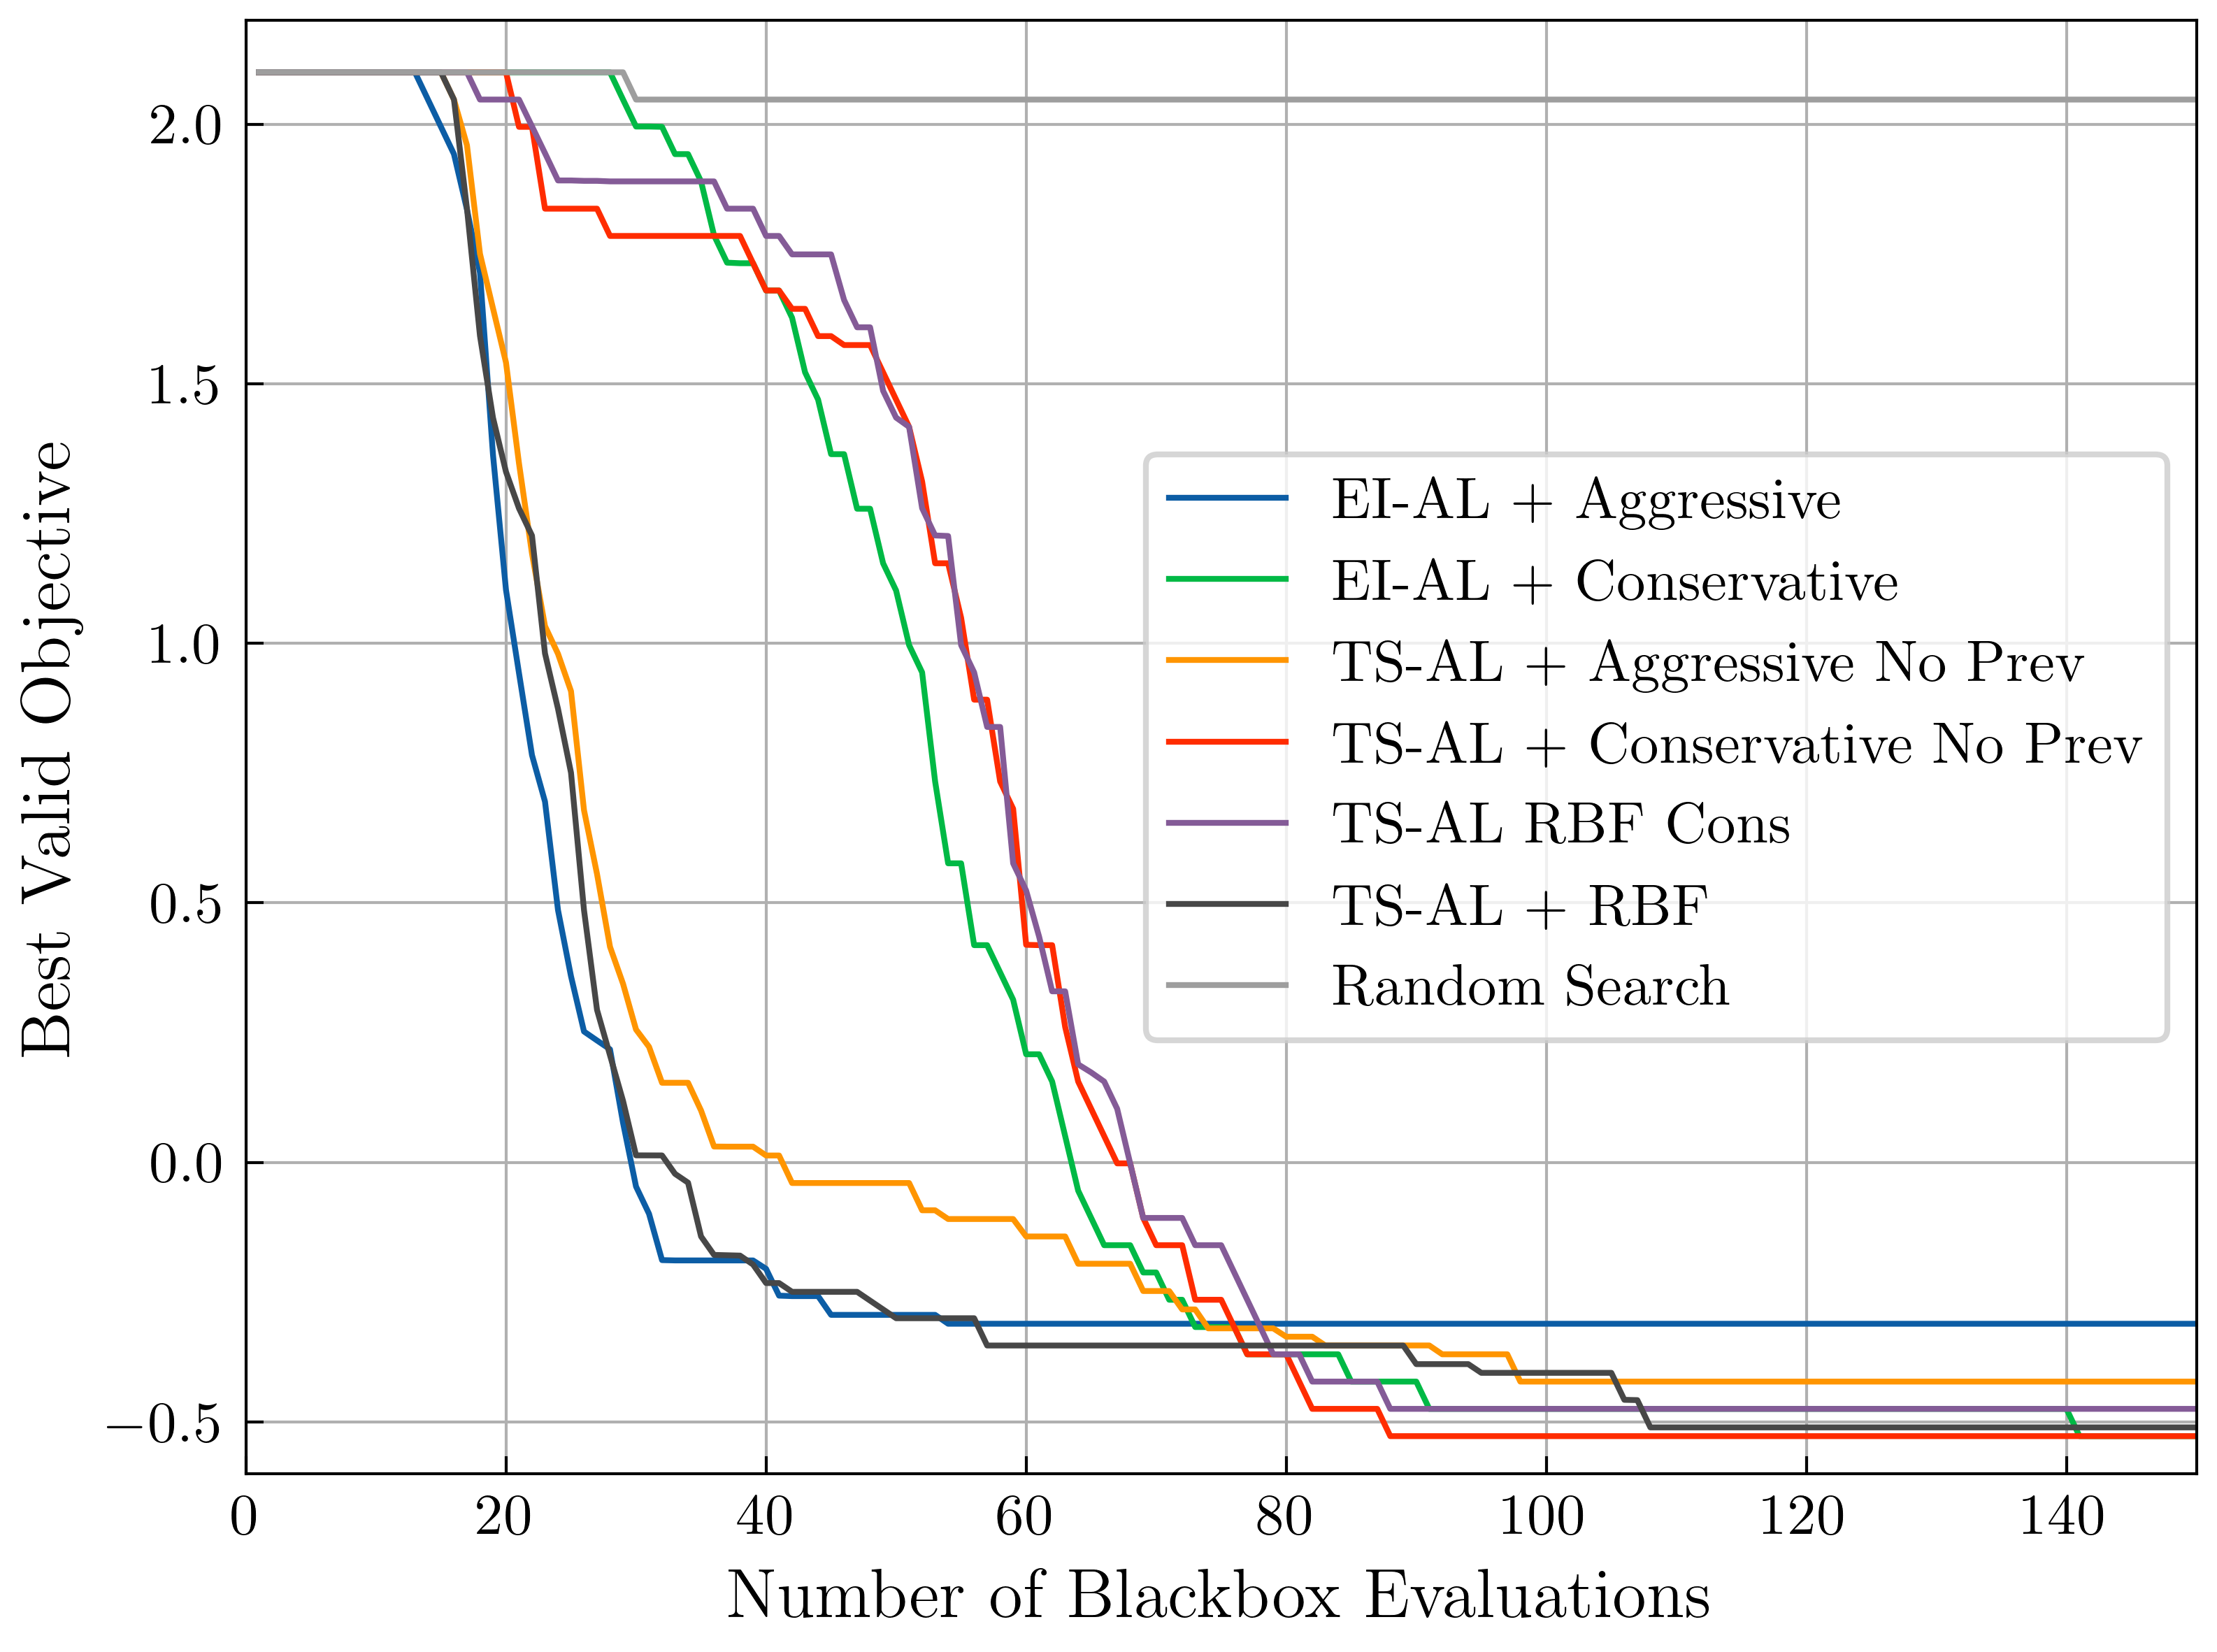

In [9]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(6, 4.5))
iters = [i for i in range(1, 151)]
plt.plot(iters, original_albo_aggressive_gsbp_results_mean, label="EI-AL + Aggressive")
plt.plot(iters, original_albo_conservative_gsbp_results_mean, label="EI-AL + Conservative")
# plt.plot(iters, ts_al_adam_aggressive_gsbp_results_mean, label="TS-AL + Aggressive")
# plt.plot(iters, ts_al_adam_conservative_gsbp_results_mean, label="TS-AL + Conservative")
plt.plot(iters, ts_al_adam_no_prev_aggressive_results_mean, label="TS-AL + Aggressive No Prev")
plt.plot(iters, ts_al_adam_no_prev_conservative_results_mean, label="TS-AL + Conservative No Prev")
plt.plot(iters, ts_al_adam_no_prev_rbf_conservative_results_mean, label="TS-AL RBF Cons")
plt.plot(iters, ts_al_adam_no_prev_rbf_aggressive_results_mean, label="TS-AL + RBF")
plt.plot(iters, random_gsbp_results_mean, label="Random Search")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 150)
plt.ylim(-0.6, 2.2)
plt.show()

In [92]:
def fraction_of_runs_found_feasible_point(all_runs: np.array,
                                          num_runs: int,
                                          failure_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_feasible_point = np.where(all_runs == failure_val, 0, 1)
    feasible_fraction = np.sum(found_feasible_point, axis=0)/num_runs
    return feasible_fraction

In [102]:
feasible_fraction_adam_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_aggressive_gsbp_results, 50, 2.1)
feasible_fraction_adam_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_conservative_gsbp_results, 50, 2.1)
feasible_fraction_random = fraction_of_runs_found_feasible_point(random_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_aggressive = fraction_of_runs_found_feasible_point(original_albo_aggressive_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_conservative = fraction_of_runs_found_feasible_point(original_albo_conservative_gsbp_results, 50, 2.1)
feasible_fraction_adam_no_prev_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_aggressive_results, 50, 2.1)
feasible_fraction_adam_no_prev_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_conservative_results, 50, 2.1)
feasible_fraction_adam_rbf_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_rbf_aggressive_results, 50, 2.1)

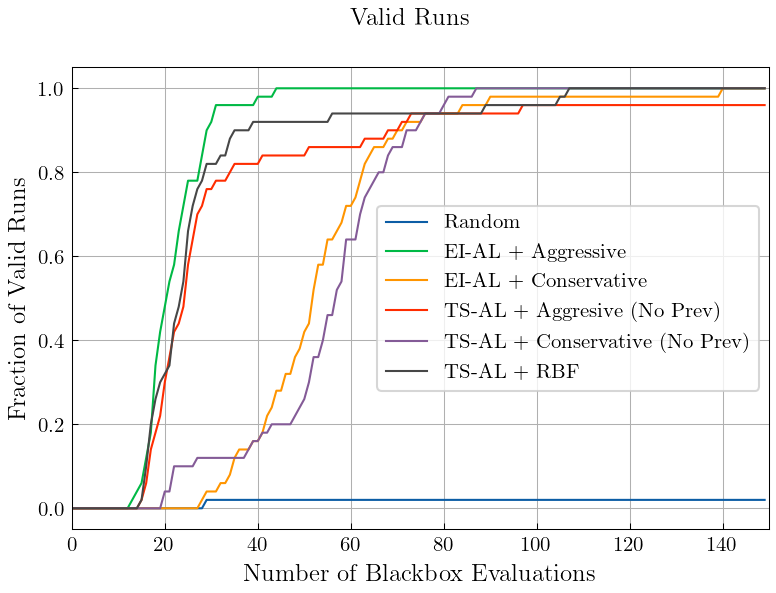

In [108]:
plt.figure(figsize=(6,4))
plt.plot(feasible_fraction_random, label="Random")
plt.plot(feasible_fraction_original_albo_aggressive, label="EI-AL + Aggressive")
plt.plot(feasible_fraction_original_albo_conservative, label="EI-AL + Conservative")
# plt.plot(feasible_fraction_adam_aggressive, label="TS-AL + Aggressive")
# plt.plot(feasible_fraction_adam_conservative, label="TS-AL + Conservative")
plt.plot(feasible_fraction_adam_no_prev_aggressive, label="TS-AL + Aggresive (No Prev)")
plt.plot(feasible_fraction_adam_no_prev_conservative, label="TS-AL + Conservative (No Prev)")
plt.plot(feasible_fraction_adam_rbf_aggressive, label="TS-AL + RBF")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Fraction of Valid Runs')
plt.suptitle("Valid Runs")
plt.legend()
plt.xlim(0, 150)
plt.legend()

In [104]:
def fraction_of_runs_found_optimal_point(all_runs: np.array,
                                         num_runs: int,
                                         optimal_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_optimal_point = np.where(all_runs == optimal_val, 1, 0)
    optimal_fraction = np.sum(found_optimal_point, axis=0)/num_runs
    return optimal_fraction

In [105]:
optimal_fraction_adam_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_aggressive_gsbp_results, 50, -0.5273951)
optimal_fraction_adam_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_conservative_gsbp_results, 50, -0.5273951)
optimal_fraction_random = fraction_of_runs_found_optimal_point(random_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_aggressive = fraction_of_runs_found_optimal_point(original_albo_aggressive_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_conservative = fraction_of_runs_found_optimal_point(original_albo_conservative_gsbp_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_aggressive_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_conservative_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_rbf_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_rbf_aggressive_results, 50, -0.5273951)

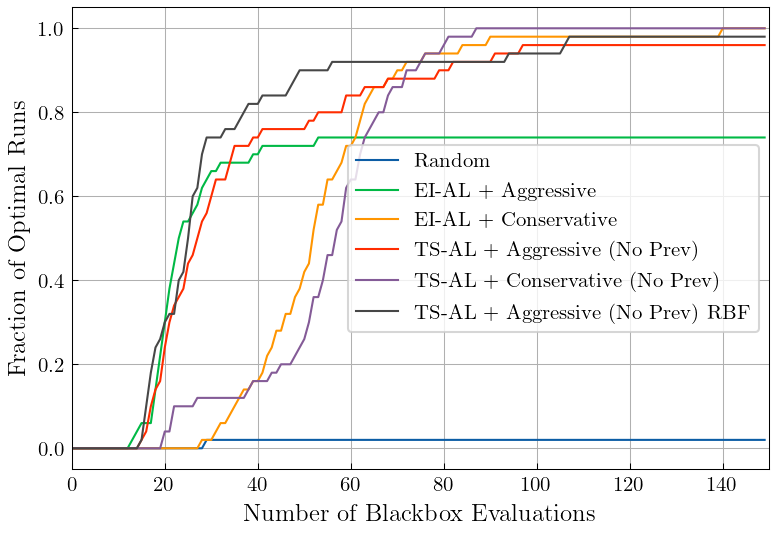

In [142]:
plt.figure(figsize=(6,4))
plt.plot(optimal_fraction_random, label="Random")
plt.plot(optimal_fraction_original_albo_aggressive, label="EI-AL + Aggressive")
plt.plot(optimal_fraction_original_albo_conservative, label="EI-AL + Conservative")
# plt.plot(optimal_fraction_adam_aggressive, label="TS-AL + Aggressive")
# plt.plot(optimal_fraction_adam_conservative, label="TS-AL + Conservative")
plt.plot(optimal_fraction_adam_no_prev_aggressive, label="TS-AL + Aggressive (No Prev)")
plt.plot(optimal_fraction_adam_no_prev_conservative, label="TS-AL + Conservative (No Prev)")
plt.plot(optimal_fraction_adam_no_prev_rbf_aggressive, label="TS-AL + Aggressive (No Prev) RBF")
plt.xlabel('Number of Blackbox Evaluations')
plt.ylabel('Fraction of Optimal Runs')
plt.legend()
plt.xlim(0, 150)
plt.legend()